In [ ]:
# Import the machine learning libraries.
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [ ]:
# Load the CIFAR10 dataset.
(x_train, _), (x_test, _) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
# Input image dimensions.
# We assume data format "channels_last".
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

In [ ]:
# Create saved_images folder.
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

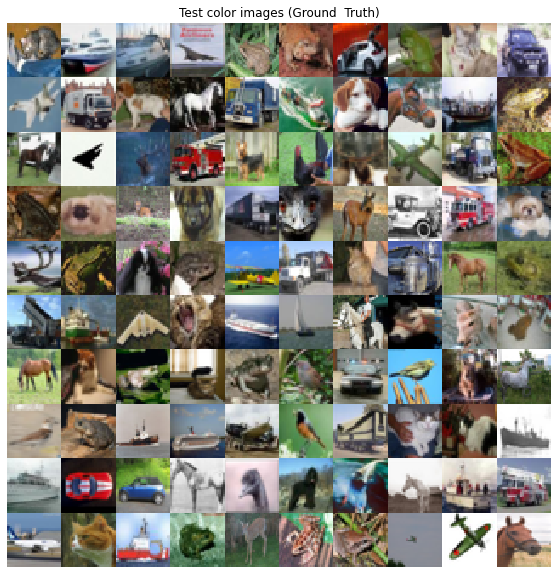

In [ ]:
# Display the 1st 100 input images (color and gray).
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.show()

In [ ]:
# Convert color train and test images to gray.
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

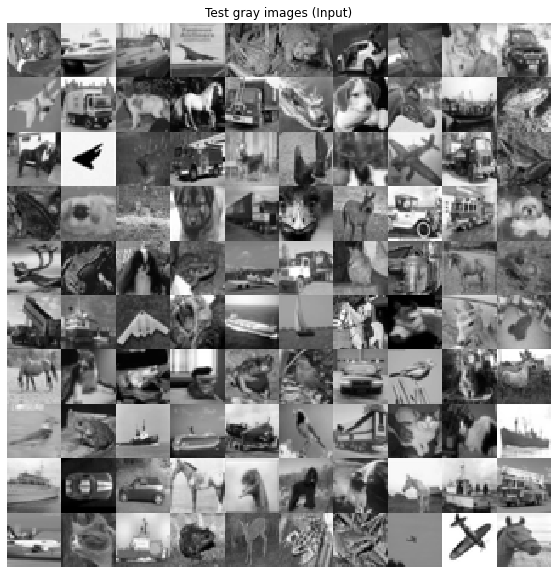

In [ ]:
# Display grayscale version of test images.
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()

In [ ]:
# Normalize output train and test color images.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
# Normalize input train and test grayscale images.
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [ ]:
# Reshape images to row x col x channel for CNN output/validation.
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

In [ ]:
# Reshape images to row x col x channel for CNN input.
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [ ]:
# Network parameters.
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
# Encoder/decoder number of CNN layers and filters per layer.
layer_filters = [64, 128, 256]

In [ ]:
# Build the autoencoder model.
# First build the encoder model.
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D(64)-Conv2D(128)-Conv2D(256).
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [ ]:
# Shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape.
# Shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3).
shape = K.int_shape(x)

In [ ]:
# Generate a latent vector.
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [ ]:
# Instantiate encoder model.
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________

In [ ]:
# Build the decoder model.
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [ ]:
# Stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64).
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [ ]:
# Instantiate decoder model.
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1052672   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731

In [ ]:
# Autoencoder = encoder + decoder
# Instantiate autoencoder model.
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 256)               1418496   
_________________________________________________________________
decoder (Functional)         (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Prepare model saving directory.
# save_dir = os.path.join(os.getcwd(), 'saved_models')
save_dir = '/content/drive/MyDrive/ML_Code/CIFAR10 Colorization Autoencoder'
model_name = 'colorized_ae_model.{epoch:03d}.h5'
# if not os.path.isdir(save_dir):
#         os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [ ]:
# Reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs.
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [ ]:
# Save weights for future use (e.g. reload parameters w/o training).
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

In [ ]:
# Mean Square Error (MSE) loss function, Adam optimizer.
autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
# Called every epoch.
callbacks = [lr_reducer, checkpoint]

In [ ]:
# Train the autoencoder.
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0155
Epoch 00001: val_loss improved from inf to 0.01117, saving model to /content/drive/MyDrive/ML_Code/CIFAR10 Colorization Autoencoder/colorized_ae_model.001.h5
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0155 - val_loss: 0.0112
Epoch 2/30
1561/1563 [============================>.] - ETA: 0s - loss: 0.0102
Epoch 00002: val_loss improved from 0.01117 to 0.00973, saving model to /content/drive/MyDrive/ML_Code/CIFAR10 Colorization Autoencoder/colorized_ae_model.002.h5
1563/1563 [==============================] - 17s 11ms/step - loss: 0.0102 - val_loss: 0.0097
Epoch 3/30
1560/1563 [============================>.] - ETA: 0s - loss: 0.0093
Epoch 00003: val_loss improved from 0.00973 to 0.00914, saving model to /content/drive/MyDrive/ML_Code/CIFAR10 Colorization Autoencoder/colorized_ae_model.003.h5
1563/1563 [==============================] - 18s 12ms/step - loss: 0.0093 - val_loss: 0.0091
Ep

In [ ]:
# Predict the autoencoder output from test data.
x_decoded = autoencoder.predict(x_test_gray)

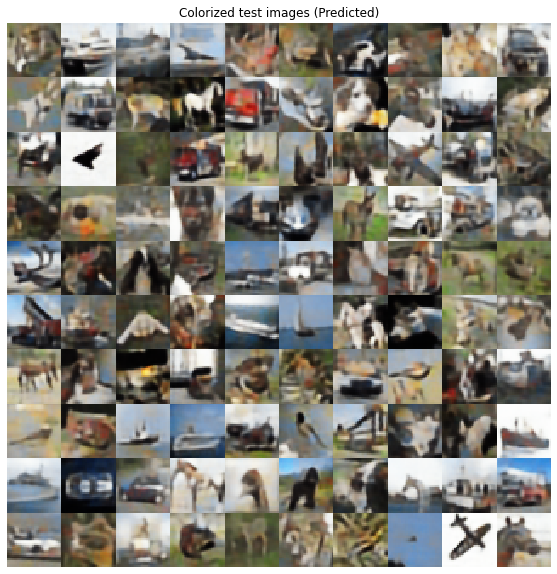

In [ ]:
# Display the 1st 100 colorized images.
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.show()